FIRST STEPS

In [ ]:
from utils import *
from validation import *

In [2]:

# Cargamos imagenes
train_images_b, train_labels_b = load_dataset_split_sobel_v4('data/original/balanced/train')
val_images_b, val_labels_b = load_dataset_split_sobel_v4('data/original/balanced/val')
test_images_b, test_labels_b = load_dataset_split_sobel_v4('data/original/balanced/test')

train_images_f, train_labels_f = load_dataset_split_sobel_v4('data/augmented/FracAtlas/train')
val_images_f, val_labels_f = load_dataset_split_sobel_v4('data/augmented/FracAtlas/val')
test_images_f, test_labels_f = load_dataset_split_sobel_v4('data/augmented/FracAtlas/test')

train_images = np.concatenate([train_images_b, train_images_f])
train_labels = np.concatenate([train_labels_b, train_labels_f])
test_images = np.concatenate([test_images_b, test_images_f])
test_labels = np.concatenate([test_labels_b, test_labels_f])
val_images = np.concatenate([val_images_b, val_images_f])
val_labels = np.concatenate([val_labels_b, val_labels_f])





In [3]:
# Creamos Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [31]:
#Calculamos pesos en función del conteo
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(train_labels), 
                                   y=train_labels)
class_weight = {0: class_weights[0], 1: class_weights[1]}


In [32]:
from tensorflow.keras import regularizers
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

In [33]:

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    class_weight=class_weight,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
320/320 [==============================] - 282s 868ms/step - loss: 3.5393 - accuracy: 0.8432 - precision_3: 0.9004 - recall_3: 0.7976 - auc_3: 0.9002 - val_loss: 5.5190 - val_accuracy: 0.4957 - val_precision_3: 1.0000 - val_recall_3: 0.0134 - val_auc_3: 0.4561 - lr: 0.0010
Epoch 2/50
320/320 [==============================] - 300s 938ms/step - loss: 1.4412 - accuracy: 0.8437 - precision_3: 0.8923 - recall_3: 0.8078 - auc_3: 0.9095 - val_loss: 1.2541 - val_accuracy: 0.5658 - val_precision_3: 0.7961 - val_recall_3: 0.2023 - val_auc_3: 0.6778 - lr: 0.0010
Epoch 3/50
320/320 [==============================] - 291s 908ms/step - loss: 1.2561 - accuracy: 0.8552 - precision_3: 0.9094 - recall_3: 0.8127 - auc_3: 0.9169 - val_loss: 0.9992 - val_accuracy: 0.6265 - val_precision_3: 0.8182 - val_recall_3: 0.3462 - val_auc_3: 0.7399 - lr: 0.0010
Epoch 4/50
320/320 [==============================] - 288s 899ms/step - loss: 1.2704 - accuracy: 0.8589 - precision_3: 0.9187 - recall_3: 0.8101 

KeyboardInterrupt: 

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

37/37 [==============================] - 7s 195ms/step - loss: 1.2725 - accuracy: 0.5942 - precision_2: 0.6554 - recall_2: 0.5222 - auc_2: 0.6195
Test Accuracy: 0.5941780805587769
Test Precision: 0.6553784608840942
Test Recall: 0.5222222208976746
Test AUC: 0.6195299625396729


37/37 [==============================] - 8s 199ms/step


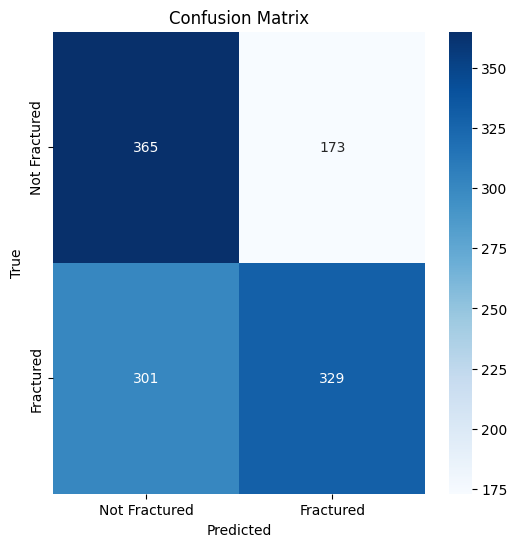

In [ ]:
plot_conf_matrix(model, test_images, test_labels)

In [ ]:
filename = 'binary_model_v5_augmented_sobel_det.pkl'
create_pkl(filename, model)

In [ ]:
model.save('binary_model_v5_augmented_det.keras') 

37/37 [==============================] - 7s 193ms/step


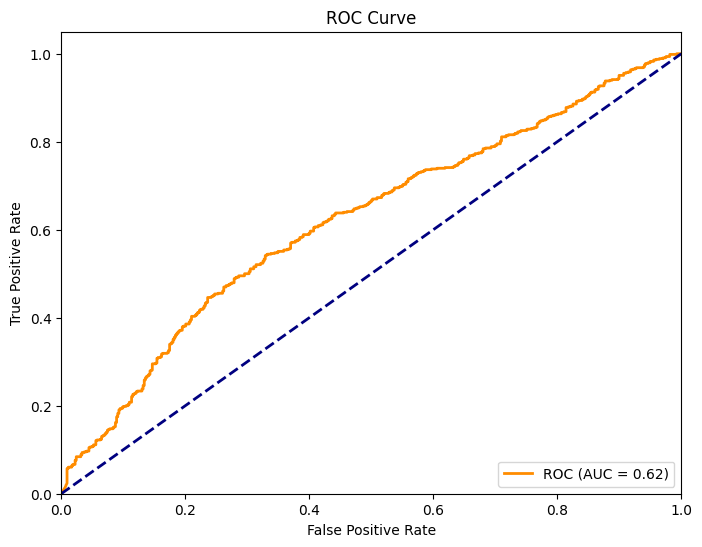

In [ ]:
plot_roc_curve(model, test_images, test_labels)

37/37 [==============================] - 8s 202ms/step


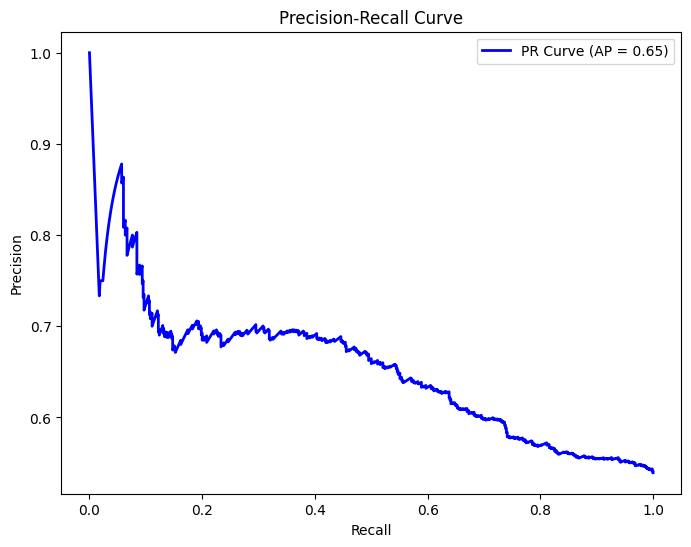

In [ ]:
plot_pr_curve(model, test_images, test_labels)

37/37 [==============================] - 7s 181ms/step


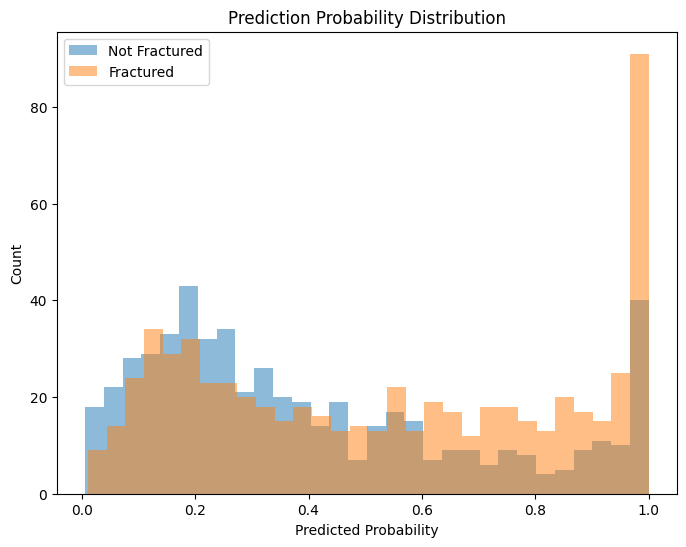

In [ ]:
p_proba_dist(model, test_images, test_labels)

37/37 [==============================] - 8s 208ms/step


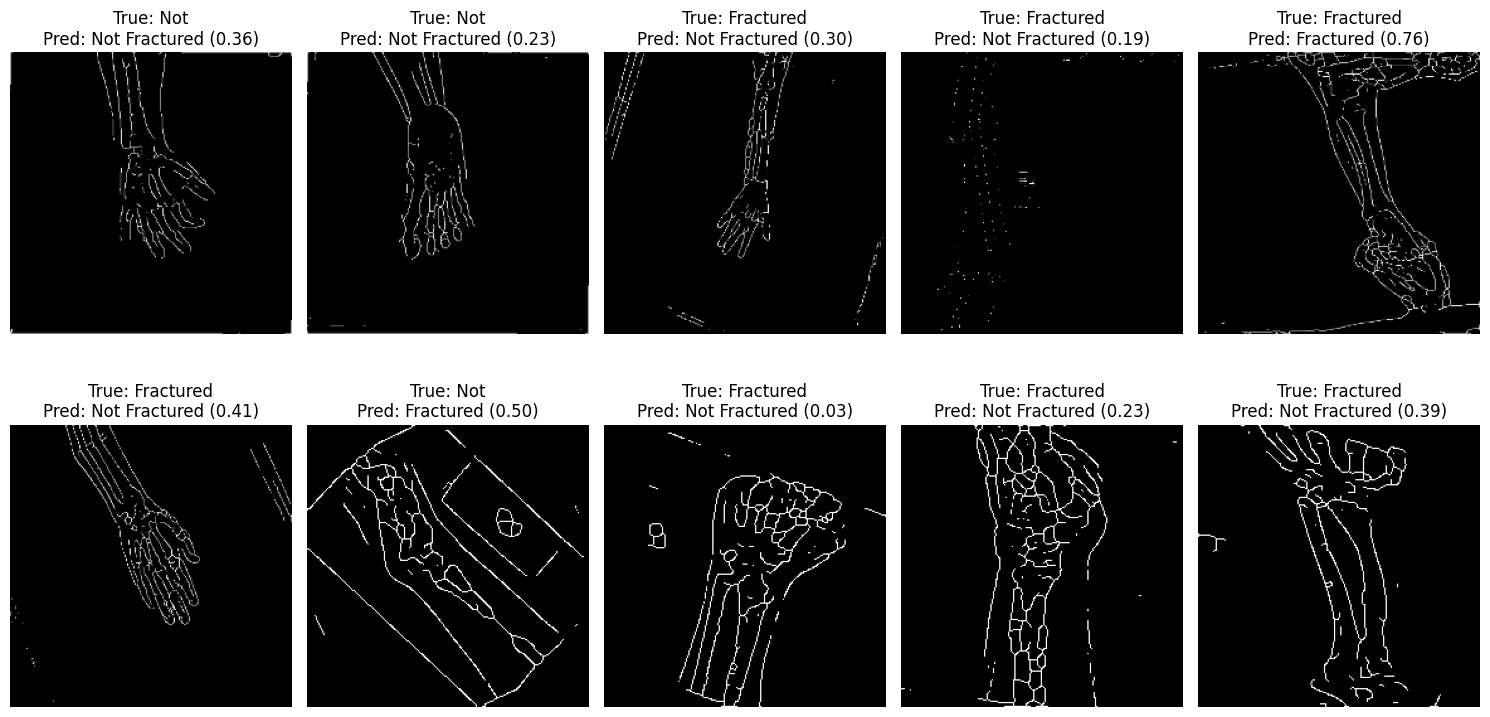

In [ ]:
show_ten_samples(model, test_images, test_labels)

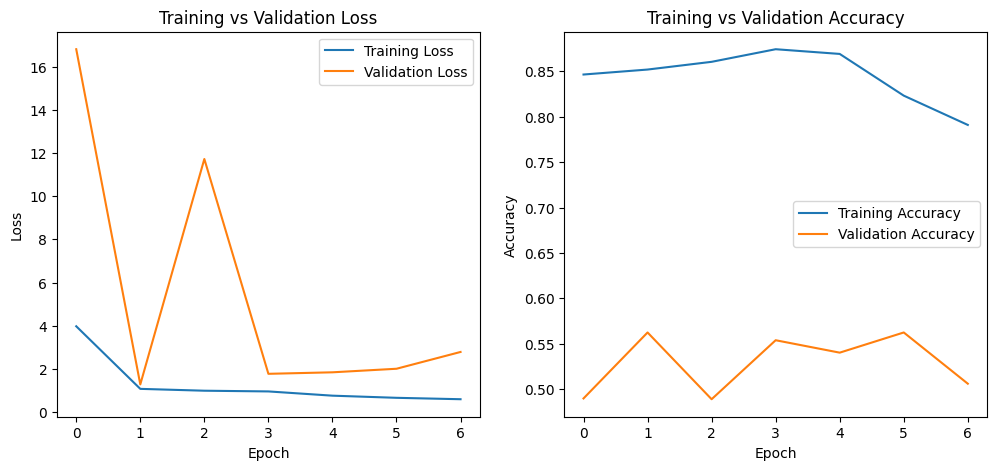

In [ ]:
loss_accu_train(history)

Revisando las métricas, vamos a ajustar 8 epochs el modelo.